In [2]:
import ROOT
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import json
from tqdm import tqdm

%matplotlib inline

Welcome to JupyROOT 6.12/04


In [1]:
from data_extraction import DataExtractor
from roboshifter import Roboshifter

de = DataExtractor()
rs = Roboshifter()

In [3]:
train_df = de.get_train_data()

X, y = train_df.drop('flag', axis=1), train_df.flag

In [4]:
rs.init_fit(X, y)
rs.fit_stat_filter()
stat_flag = rs.info[True]['stat_flag']
sf = y.copy()
sf[stat_flag == 1] += 2

fitting stat filter
predicting stat filter
finished predicting stat filter
finished fitting stat filter


roboshifter.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ndf['runssum'] = X[stat_cols].sum(axis=1)


In [14]:
FLAG_COLORS = {0: 'b', 1: 'r', 2: 'g', 3: 'y'}

In [5]:
df = de.get_train_data()
histo_types = de.get_histo_types()
histo_keys = [str(key) for key in de.get_histo_keys() 
              if histo_types[key] == 'TH1D']

In [6]:
result = []

for run_number in tqdm(df.index):
    runh, refh = de.get_run(run_number), de.get_reference(run_number)
    result.append([])

    for hk in histo_keys:
        histos = [runh[hk], refh[hk]]

        integrals = [histo['integral'] for histo in histos]
        n_bins = len(histos[0]['xs'])
        contents = [histo['vals'] for histo in histos]
        errors = [histo['errors'] for histo in histos]

        index = (contents[0] != 0) & (contents[1] != 0)

        st = np.sum((contents[0][index] / integrals[0] - 
                     contents[1][index] / integrals[1]) ** 2 / 
                    np.sqrt((errors[0][index] / integrals[0]) ** 2 + 
                            (errors[1][index] / integrals[1]) ** 2)) / n_bins
        st1 = np.sum(np.abs((contents[0][index] / integrals[0] - contents[1][index] / integrals[1])))

        result[-1].extend([integrals[0], st, st1])

100%|██████████| 2495/2495 [21:25<00:00,  3.00it/s]


In [9]:
rdf = pd.DataFrame(result, index=df.index, 
                   columns=sum([[(hk, 'stats'), (hk, 'chi2'), (hk, 'l1')] 
                                for hk in histo_keys], []))

In [27]:
def clean(hk, feature):
    data = rdf[(hk, feature)]
        
    index = (data > data.sort_values().iloc[500])

    return rdf.loc[index][(hk, 'stats')], 1. / data.loc[index]

def comparison(hk):
    print hk
    
    f, subplots = plt.subplots(2, 2, figsize=(20, 10))
    plt.subplots_adjust(bottom=0.01)
    
    for title, (ax1, ax2) in zip(['chi2', 'l1'], subplots):
        ax1.set_title(title, fontsize=20)
        ax2.set_title(title, fontsize=20)

        x, y = clean(hk, title)
        ax1.set_xlabel('statistics', size=15)
        ax1.set_ylabel(title, size=15)
        ax1.scatter(x, y, c=sf.map(FLAG_COLORS), alpha=0.5)

        series = rdf[(hk, title)]
        ax2.hist(series[df.flag == 1], bins=100, alpha=0.4, normed=True, label='Bad runs')
        ax2.hist(series[df.flag == 0], bins=100, alpha=0.4, normed=True, label='Good runs')
        ax2.legend()

    plt.show()

Track/TrackVertexMonitor/PV right-Right half x


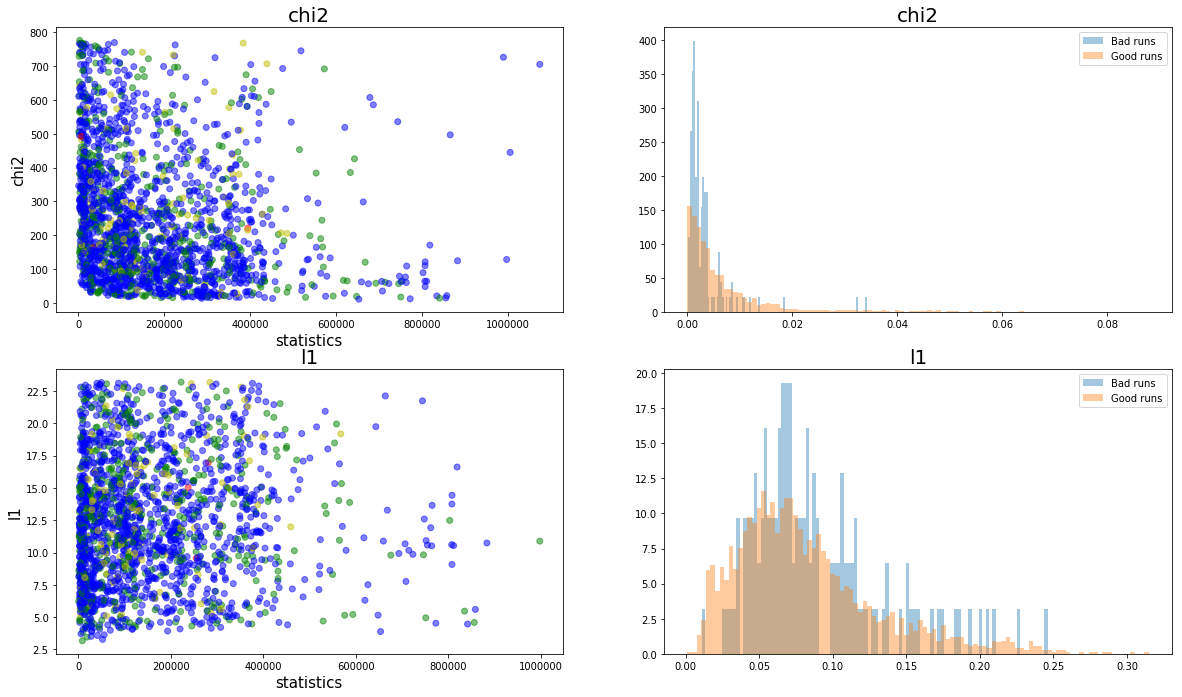

Track/TrackVertexMonitor/twoprong IP chi2 per dof


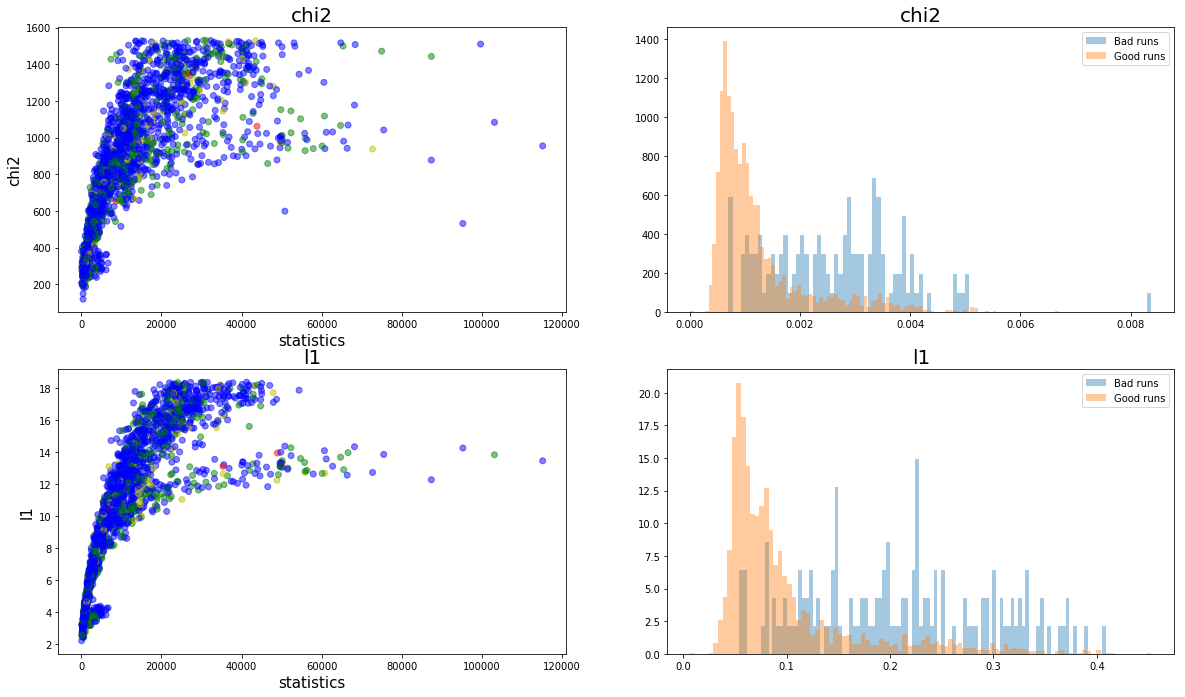

RichDstarToD0PiSelPlots.MassPlotTool/all/M_Dst_2010_plus


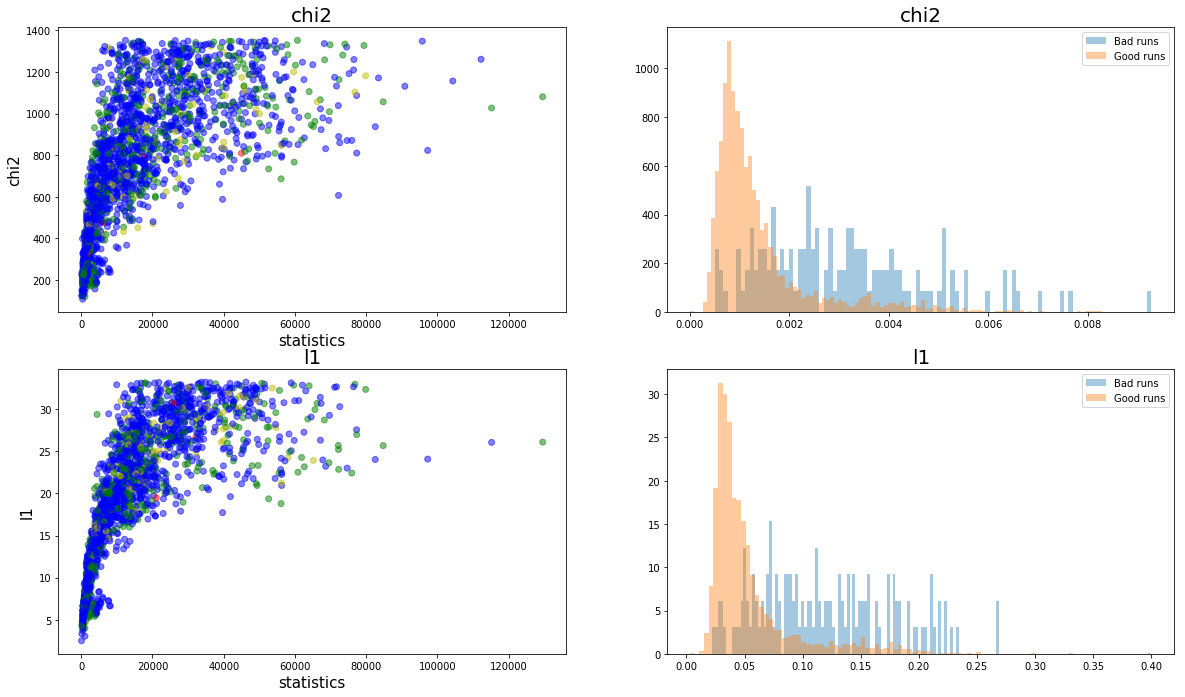

Track/TTTrackMonitor/TTaU/Overlap residual


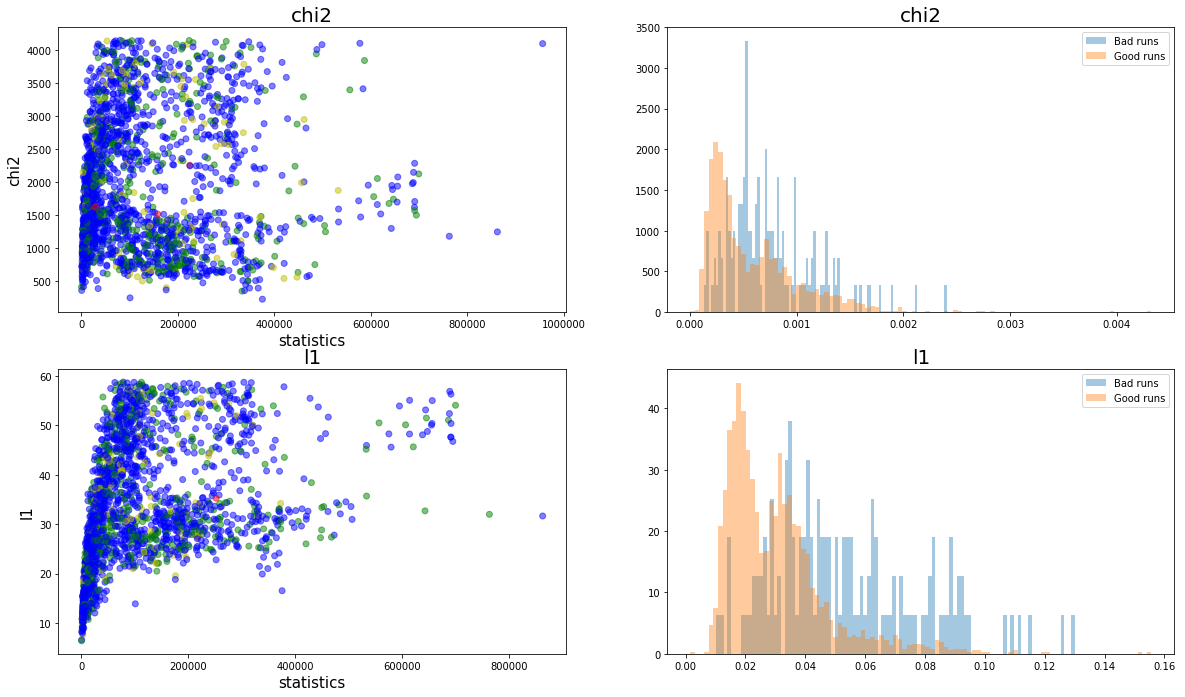

Track/TrackMonitor/Long/chi2PerDofMatch


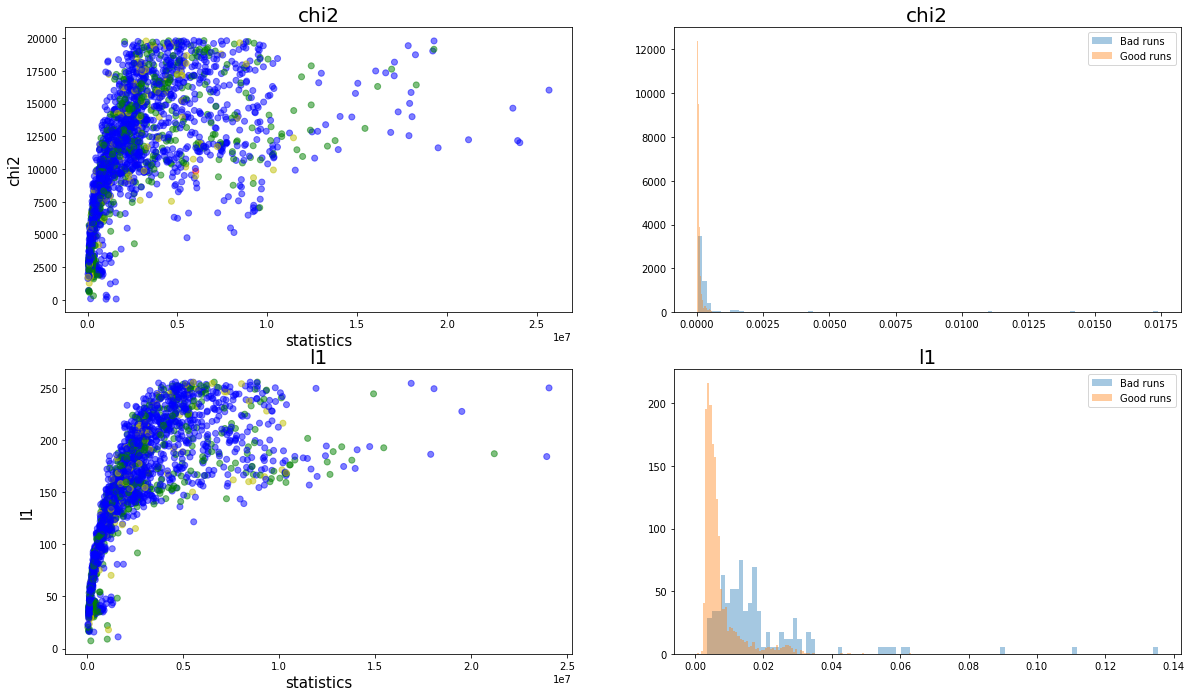

Track/TrackVertexMonitor/NumTracksPerPV


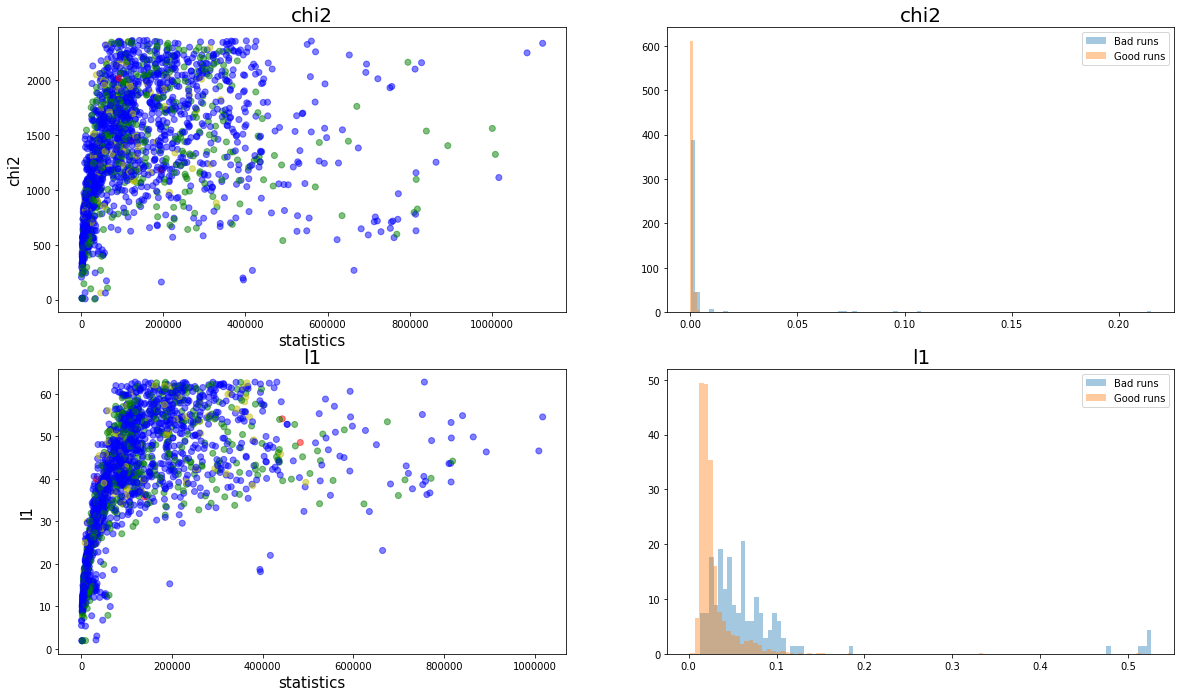

Muon/MuonPID/MonitorLong/hNIMtracks


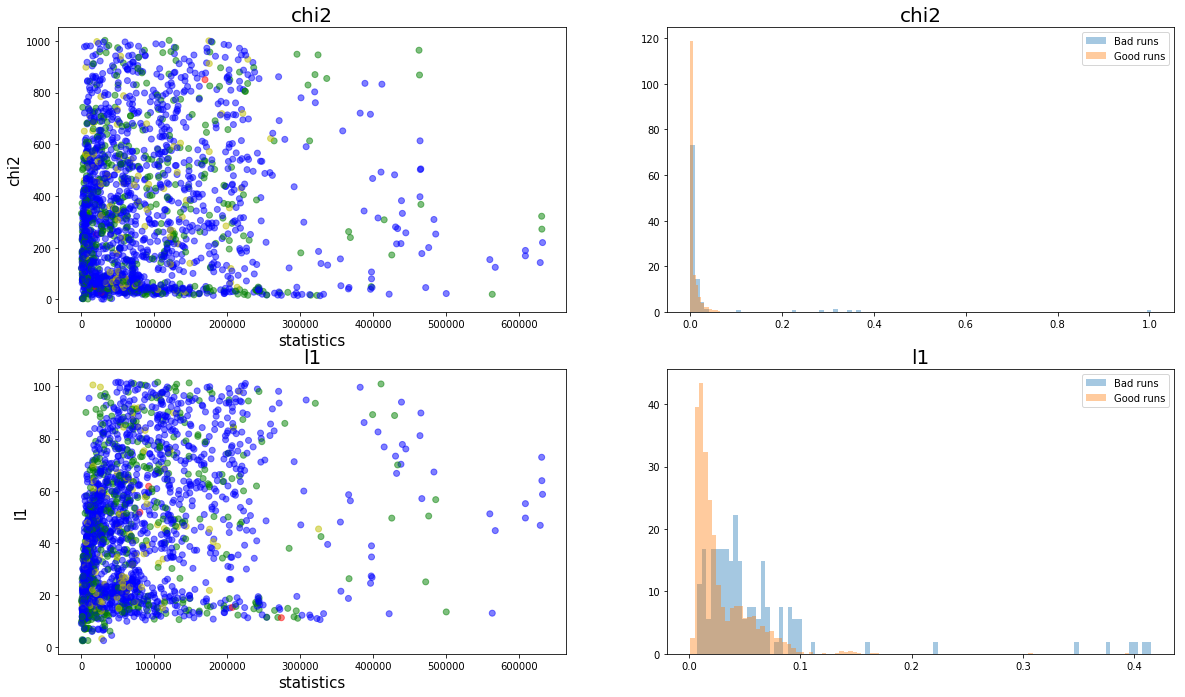

Velo/VeloClusterMonitor/Cluster size


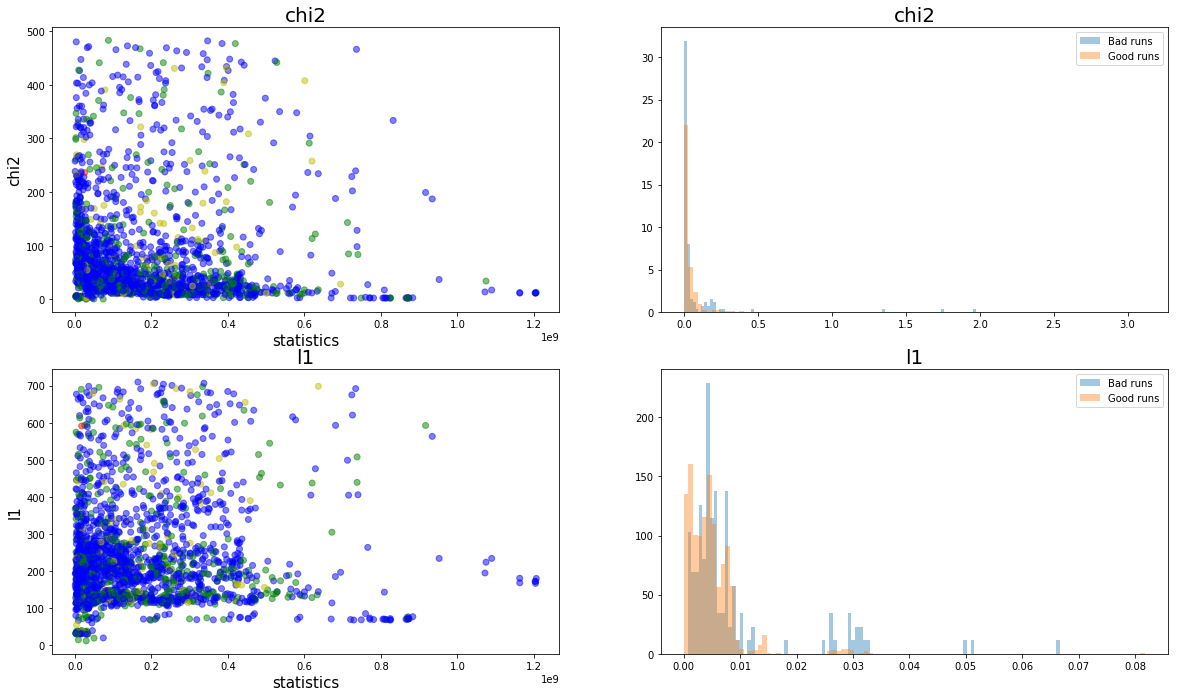

Muon/MuonPID/MonitorLong/hNIMtracks


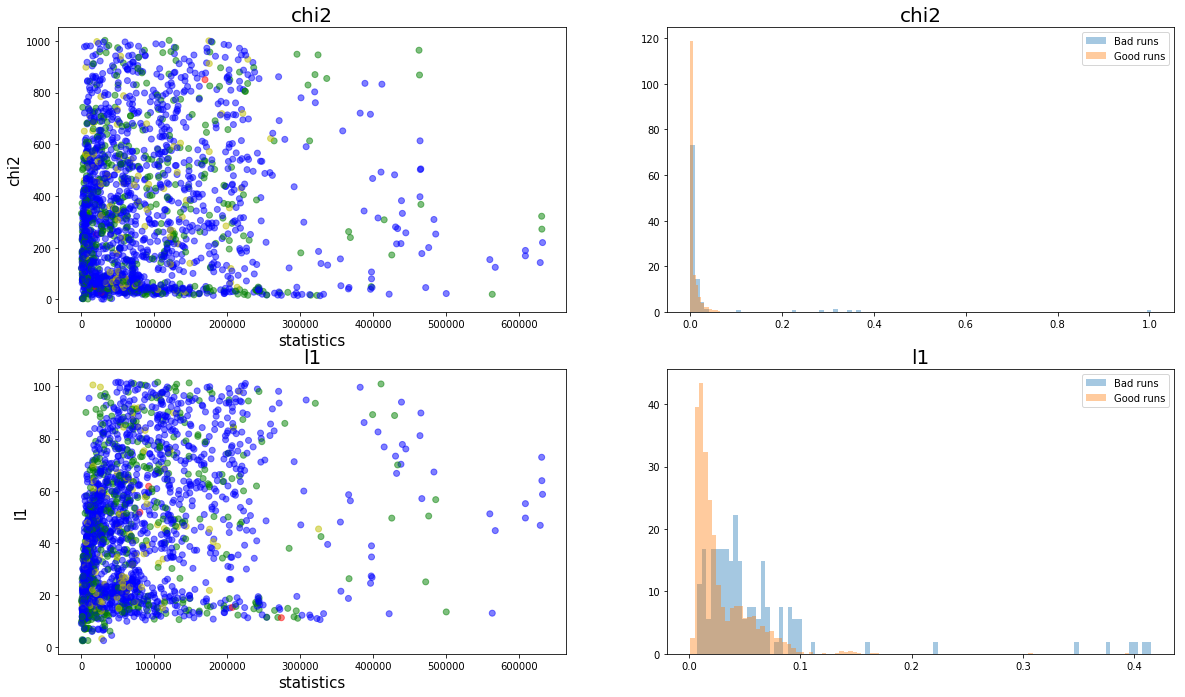

Track/TrackMonitor/Long/ITResidual


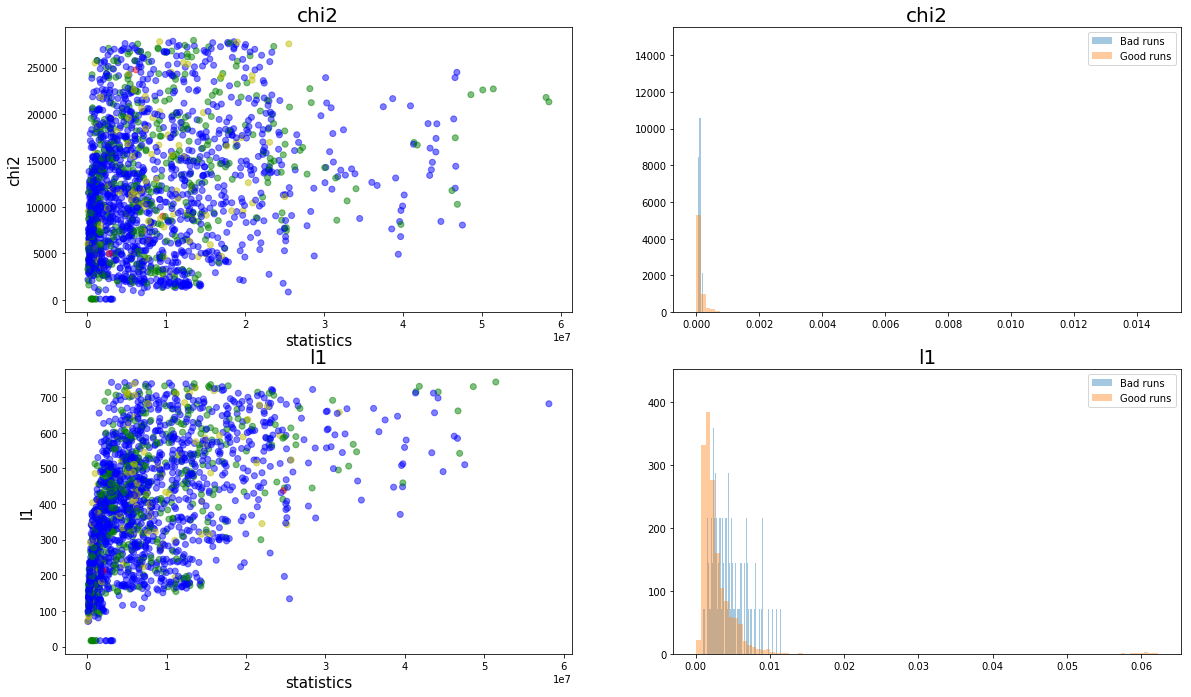

In [28]:
for hk in np.random.choice(histo_keys, 10):
    comparison(hk)